In [1]:
pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e94cd5aefaed264496d0ca7129e6cb24d23eb0dfbbdcfcbb1c47ba98ca38d319
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import math
import time
import evaluate

# New imports for EDA & preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import re
import unicodedata
from datasets import Dataset as HFDataset, DatasetDict, load_dataset

2025-05-14 00:16:46.145181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747181806.356429      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747181806.410142      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

In [5]:
# Data Preparation: load, EDA, preprocessing (10% sample)
dataset = load_dataset("Helsinki-NLP/opus-100", "en-vi")

README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
# Take a 10% slice across train/validation/test
all_data = []
for split in ["train", "validation", "test"]:
    all_data.extend(dataset[split])
total_samples = int(len(all_data) * 0.10)
sampled_data = all_data[:total_samples]
print(f"Total samples: {len(sampled_data)}")

Total samples: 100400


In [7]:
# Build a pandas DataFrame for EDA
df = pd.DataFrame([
    {"en": ex["translation"]["en"], "vi": ex["translation"]["vi"]}
    for ex in sampled_data
])

In [8]:
# Raw-length and null/duplicate checks
df["en_len"] = df["en"].str.len()
df["vi_len"] = df["vi"].str.len()

print(f"English nulls: {df['en'].isnull().sum()}")
print(f"Vietnamese nulls: {df['vi'].isnull().sum()}\n")

print(f"Duplicate English: {df.duplicated(subset=['en']).sum()}")
print(f"Duplicate Vietnamese: {df.duplicated(subset=['vi']).sum()}")
print(f"Duplicate pairs: {df.duplicated().sum()}\n")

print(f"Very long English (>=200): {(df['en_len'] >= 200).sum()}")
print(f"Very long Vietnamese (>=200): {(df['vi_len'] >= 200).sum()}\n")

English nulls: 0
Vietnamese nulls: 0

Duplicate English: 11047
Duplicate Vietnamese: 8255
Duplicate pairs: 4088

Very long English (>=200): 102
Very long Vietnamese (>=200): 90



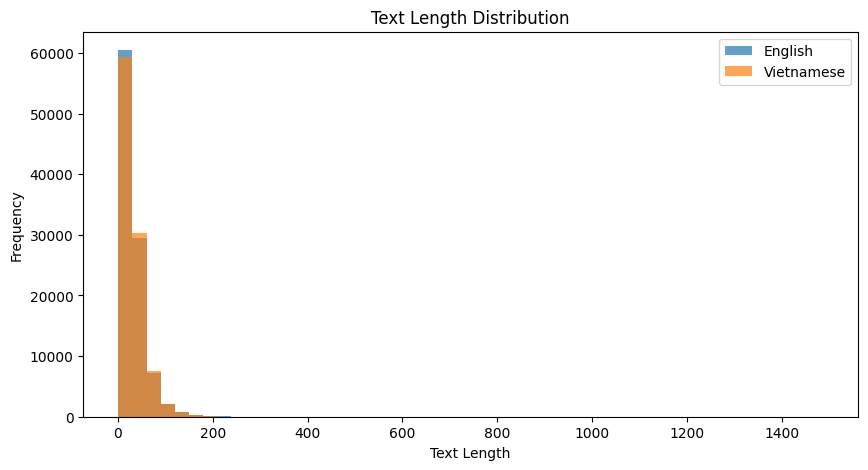

In [9]:
# Plot length distributions
plt.figure(figsize=(10, 5))
plt.hist(df["en_len"], bins=50, alpha=0.7, label="English")
plt.hist(df["vi_len"], bins=50, alpha=0.7, label="Vietnamese")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.legend()
plt.show()

In [10]:
# Character set sizes
en_chars = set("".join(df["en"].tolist()))
vi_chars = set("".join(df["vi"].tolist()))
print(f"Unique English characters: {len(en_chars)}")
print(f"Unique Vietnamese characters: {len(vi_chars)}\n")

Unique English characters: 213
Unique Vietnamese characters: 460



In [11]:
# Preprocessing functions
def preprocess_text(text, lowercase=True):
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Remove special chars but keep punctuation
    text = re.sub(r"[^\w\s.,!?-]", "", text)
    # Unicode normalization
    text = unicodedata.normalize("NFC", text)
    if lowercase:
        text = text.lower()
    return text

def clean_dataset(df):
    df = df.dropna(subset=["en_clean", "vi_clean"])
    df = df[(df["en_clean"].str.len() > 0) & (df["vi_clean"].str.len() > 0)]
    df = df.drop_duplicates(subset=["en_clean", "vi_clean"])
    df = df[(df["en_clean_len"] >= 3) & (df["en_clean_len"] <= 200)]
    df = df[(df["vi_clean_len"] >= 3) & (df["vi_clean_len"] <= 200)]
    length_ratio = df["vi_clean_len"] / df["en_clean_len"]
    df = df[(length_ratio >= 0.3) & (length_ratio <= 3.0)]
    return df

In [12]:
# Apply preprocessing
print("Preprocessing data...")
df["en_clean"] = df["en"].map(lambda x: preprocess_text(x, True))
df["vi_clean"] = df["vi"].map(lambda x: preprocess_text(x, True))
df["en_clean_len"] = df["en_clean"].str.len()
df["vi_clean_len"] = df["vi_clean"].str.len()

Preprocessing data...


In [13]:
# Clean and report removals
print("Cleaning data...")
df_clean = clean_dataset(df)
removed = len(df) - len(df_clean)
print(f"Removed {removed} samples ({removed/len(df)*100:.1f}%)\n")

Cleaning data...
Removed 5759 samples (5.7%)



In [14]:
#  Split into train/validation/test (80/10/10)
train_df = df_clean.sample(frac=0.8, random_state=42)
temp_df  = df_clean.drop(train_df.index)
val_df   = temp_df.sample(frac=0.5, random_state=42)
test_df  = temp_df.drop(val_df.index)

print(f"Training set:   {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set:       {len(test_df)} samples\n")

Training set:   75713 samples
Validation set: 9464 samples
Test set:       9464 samples



In [15]:
# Convert back to 🤗 Datasets
train_dataset = HFDataset.from_pandas(train_df[["en_clean","vi_clean"]].reset_index(drop=True))
val_dataset   = HFDataset.from_pandas(val_df[["en_clean","vi_clean"]].reset_index(drop=True))
test_dataset  = HFDataset.from_pandas(test_df[["en_clean","vi_clean"]].reset_index(drop=True))

sampled_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

In [16]:
# Prepare texts for tokenizer training
en_texts = train_df["en_clean"].tolist()
vi_texts = train_df["vi_clean"].tolist()

In [17]:
# Improved BPE Tokenizer with better space handling
class BPETokenizer:
    def __init__(self, vocab_size=8000):
        self.vocab_size = vocab_size
        self.special_tokens = {
            "<PAD>": 0,
            "<UNK>": 1,
            "<SOS>": 2,
            "<EOS>": 3,
        }
        self.vocab = {k: v for k, v in self.special_tokens.items()}
        self.merges = {}

    def train(self, texts, min_freq=2):
        # Preprocess texts - add special marker before each space
        processed_texts = []
        for text in texts:
            # Replace spaces with a special marker
            processed_texts.append(text.lower().replace(' ', ' ▁'))

        # Build vocabulary
        words = []
        for text in processed_texts:
            words.extend(text.split())
        word_freqs = Counter(words)

        # Initialize character-level encoding
        char_dict = {}
        for word, freq in word_freqs.items():
            if freq < min_freq:
                continue
            char_dict[word] = ' '.join(list(word))

        # Add characters to vocab
        char_set = set()
        for chars in char_dict.values():
            char_set.update(chars.split())

        for char in sorted(char_set):
            if char not in self.vocab:
                self.vocab[char] = len(self.vocab)

        # BPE algorithm: merge most frequent pairs
        while len(self.vocab) < self.vocab_size:
            pairs = Counter()
            for word, split_word in char_dict.items():
                symbols = split_word.split()
                for i in range(len(symbols) - 1):
                    pairs[(symbols[i], symbols[i+1])] += word_freqs[word]

            if not pairs:
                break

            best_pair = max(pairs, key=pairs.get)
            new_token = ''.join(best_pair)
            self.vocab[new_token] = len(self.vocab)

            # Update all words with the new merged token
            for word in char_dict:
                symbols = char_dict[word].split()
                i = 0
                new_symbols = []
                while i < len(symbols):
                    if i < len(symbols) - 1 and (symbols[i], symbols[i+1]) == best_pair:
                        new_symbols.append(new_token)
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                char_dict[word] = ' '.join(new_symbols)

            self.merges[best_pair] = new_token

        # Create reverse mapping
        self.id_to_token = {v: k for k, v in self.vocab.items()}

    def encode(self, text):
        # Add space marker
        text = text.lower().replace(' ', ' ▁')

        words = text.split()
        result = [self.special_tokens["<SOS>"]]

        for word in words:
            # Start with character-level
            chars = ' '.join(list(word))
            subwords = chars.split()

            # Apply merges
            while len(subwords) > 1:
                pairs = [(subwords[i], subwords[i+1])
                        for i in range(len(subwords) - 1)]
                merged = False

                for pair in pairs:
                    if pair in self.merges:
                        idx = subwords.index(pair[0])
                        subwords = subwords[:idx] + [self.merges[pair]] + subwords[idx+2:]
                        merged = True
                        break

                if not merged:
                    break

            # Add subwords to result
            for subword in subwords:
                result.append(self.vocab.get(subword, self.special_tokens["<UNK>"]))

        result.append(self.special_tokens["<EOS>"])
        return result

    def decode(self, ids):
        tokens = [self.id_to_token.get(id, "<UNK>") for id in ids
                 if id not in [0, 2, 3]]  # Skip PAD, SOS, EOS

        # Join and replace space markers with actual spaces
        text = ''.join(tokens).replace('▁', ' ').strip()
        return text

In [18]:
# Train tokenizers
src_tokenizer = BPETokenizer(vocab_size=10000)
trg_tokenizer = BPETokenizer(vocab_size=10000)

print("Training source tokenizer...")
src_tokenizer.train(en_texts)
print("Training target tokenizer...")
trg_tokenizer.train(vi_texts)

Training source tokenizer...
Training target tokenizer...


In [19]:
# Dataset and dataloader
class TranslationDataset(Dataset):
    def __init__(self, data, src_tokenizer, trg_tokenizer):
        self.data = data
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        src_text = item['en_clean']
        trg_text = item['vi_clean']

        src_tokens = self.src_tokenizer.encode(src_text)
        trg_tokens = self.trg_tokenizer.encode(trg_text)

        return {
            'src': torch.tensor(src_tokens, dtype=torch.long),
            'trg': torch.tensor(trg_tokens, dtype=torch.long),
            'src_text': src_text,
            'trg_text': trg_text
        }

def collate_fn(batch):
    src_batch = [item['src'] for item in batch]
    trg_batch = [item['trg'] for item in batch]
    src_text = [item['src_text'] for item in batch]
    trg_text = [item['trg_text'] for item in batch]

    src_lengths = [len(x) for x in src_batch]
    trg_lengths = [len(x) for x in trg_batch]

    max_src_len = max(src_lengths)
    max_trg_len = max(trg_lengths)

    # Pad sequences
    src_padded = torch.zeros(len(batch), max_src_len, dtype=torch.long)
    trg_padded = torch.zeros(len(batch), max_trg_len, dtype=torch.long)

    for i, (src, trg) in enumerate(zip(src_batch, trg_batch)):
        src_padded[i, :len(src)] = src
        trg_padded[i, :len(trg)] = trg

    return src_padded, trg_padded, src_text, trg_text

# Create dataloaders
train_dataset = TranslationDataset(sampled_dataset['train'], src_tokenizer, trg_tokenizer)
valid_dataset = TranslationDataset(sampled_dataset['validation'], src_tokenizer, trg_tokenizer)
test_dataset = TranslationDataset(sampled_dataset['test'], src_tokenizer, trg_tokenizer)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [20]:
# Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000):
        super().__init__()
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model=128, n_layers=2,
                 n_heads=4, d_ff=256, dropout=0.1):
        super().__init__()

        # Embeddings
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # Use manual self-attention to avoid nested tensor warning
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, n_layers)

        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self.d_model = d_model
        self.src_pad_idx = 0  # PAD token
        self.trg_pad_idx = 0  # PAD token

    def make_src_mask(self, src):
        # Create source padding mask for attention
        return (src == self.src_pad_idx)

    def make_trg_mask(self, trg):
        # Create target padding mask
        trg_pad_mask = (trg == self.trg_pad_idx)

        # Create triangular causal mask to prevent seeing future tokens
        trg_len = trg.shape[1]
        trg_sub_mask = torch.triu(torch.ones((trg_len, trg_len)), diagonal=1).bool().to(device)

        return trg_pad_mask, trg_sub_mask

    def forward(self, src, trg):
        # Create masks
        src_mask = self.make_src_mask(src)
        trg_pad_mask, trg_sub_mask = self.make_trg_mask(trg)

        # Embeddings and positional encoding
        src_emb = self.pos_encoder(self.encoder_embedding(src) * math.sqrt(self.d_model))
        trg_emb = self.pos_encoder(self.decoder_embedding(trg) * math.sqrt(self.d_model))

        # Encoder
        enc_output = self.encoder(src_emb, src_key_padding_mask=src_mask)

        # Decoder (PyTorch's transformer expects different mask format)
        output = self.decoder(
            trg_emb,
            enc_output,
            tgt_mask=trg_sub_mask,
            tgt_key_padding_mask=trg_pad_mask,
            memory_key_padding_mask=src_mask
        )

        return self.fc_out(output)

In [21]:
# Initialize model
src_vocab_size = len(src_tokenizer.vocab)
trg_vocab_size = len(trg_tokenizer.vocab)

model = Transformer(
    src_vocab_size=src_vocab_size,
    trg_vocab_size=trg_vocab_size,
    d_model=256,
    n_layers=4,
    n_heads=8,
    d_ff=512,
    dropout=0.1
).to(device)

# Initialize weights
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding

In [22]:
# Training functions
def train_epoch(model, dataloader, optimizer, criterion, clip=1.0):
    model.train()
    epoch_loss = 0

    for src, trg, _, _ in dataloader:  # Ignore text, only use tensors
        src, trg = src.to(device), trg.to(device)

        # Forward pass with teacher forcing
        optimizer.zero_grad()
        output = model(src, trg[:, :-1])

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        # Calculate loss, backprop and update
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg, _, _ in dataloader:  # Ignore text, only use tensors
            src, trg = src.to(device), trg.to(device)

            # Forward pass
            output = model(src, trg[:, :-1])

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            # Calculate loss
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [28]:
# Training loop
N_EPOCHS = 20
best_valid_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss = evaluate_epoch(model, valid_loader, criterion)

    # Learning rate scheduling
    scheduler.step(valid_loss)

    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) % 60)

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-en-vi-model.pt', _use_new_zipfile_serialization=True)
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train PPL: {math.exp(train_loss):7.4f}')
    print(f'\t Val. Loss: {valid_loss:.4f} |  Val. PPL: {math.exp(valid_loss):7.4f}')

    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break

Epoch: 01 | Time: 2m 54s
	Train Loss: 3.5016 | Train PPL: 33.1675
	 Val. Loss: 3.3866 |  Val. PPL: 29.5659
Epoch: 02 | Time: 3m 20s
	Train Loss: 3.2831 | Train PPL: 26.6588
	 Val. Loss: 3.2252 |  Val. PPL: 25.1580
Epoch: 03 | Time: 3m 12s
	Train Loss: 3.1119 | Train PPL: 22.4635
	 Val. Loss: 3.1056 |  Val. PPL: 22.3227
Epoch: 04 | Time: 3m 2s
	Train Loss: 2.9635 | Train PPL: 19.3647
	 Val. Loss: 3.0070 |  Val. PPL: 20.2271
Epoch: 05 | Time: 3m 25s
	Train Loss: 2.8377 | Train PPL: 17.0765
	 Val. Loss: 2.9365 |  Val. PPL: 18.8503
Epoch: 06 | Time: 2m 51s
	Train Loss: 2.7257 | Train PPL: 15.2673
	 Val. Loss: 2.8775 |  Val. PPL: 17.7691
Epoch: 07 | Time: 3m 5s
	Train Loss: 2.6261 | Train PPL: 13.8191
	 Val. Loss: 2.8227 |  Val. PPL: 16.8221
Epoch: 08 | Time: 2m 44s
	Train Loss: 2.5354 | Train PPL: 12.6212
	 Val. Loss: 2.7872 |  Val. PPL: 16.2353
Epoch: 09 | Time: 2m 45s
	Train Loss: 2.4518 | Train PPL: 11.6093
	 Val. Loss: 2.7567 |  Val. PPL: 15.7477
Epoch: 10 | Time: 2m 45s
	Train Loss: 2

In [33]:
# Inference function
def translate_sentence(model, sentence, src_tokenizer, trg_tokenizer, max_len=70):
    model.eval()

    # Tokenize and encode source sentence
    tokens = src_tokenizer.encode(sentence)
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

    # Initialize with SOS token
    trg_indexes = [trg_tokenizer.special_tokens["<SOS>"]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            output = model(src_tensor, trg_tensor)

        # Get next token
        pred_token = output[:, -1, :].argmax(1).item()
        trg_indexes.append(pred_token)

        # Stop if EOS token
        if pred_token == trg_tokenizer.special_tokens["<EOS>"]:
            break

    # Convert tokens to text
    translated_sentence = trg_tokenizer.decode(trg_indexes)

    return translated_sentence

In [34]:
# Fixed evaluation function
def calculate_metrics(model, test_loader, src_tokenizer, trg_tokenizer):
    model.eval()

    references = []
    predictions = []

    with torch.no_grad():
        for src, trg, src_texts, trg_texts in test_loader:
            src = src.to(device)

            for i in range(min(len(src), 10)):  # Process fewer examples per batch
                try:
                    # Get source and reference texts directly
                    src_text = src_texts[i]
                    trg_text = trg_texts[i]

                    # Generate translation
                    pred_text = translate_sentence(model, src_text, src_tokenizer, trg_tokenizer)

                    # Only add if both are non-empty
                    if pred_text and trg_text:
                        references.append(trg_text)
                        predictions.append(pred_text)
                except Exception as e:
                    print(f"Error translating: {e}")

    # Ensure we have samples to evaluate
    if not predictions or not references:
        return {
            'bleu': 0.0,
            'rouge1': 0.0,
            'rouge2': 0.0,
            'rougeL': 0.0,
            'num_samples': 0
        }

    # Calculate BLEU
    bleu_results = bleu.compute(predictions=predictions, references=[[r] for r in references])

    # Calculate ROUGE
    rouge_results = rouge.compute(
        predictions=predictions,
        references=references
    )

    return {
        'bleu': bleu_results['bleu'],
        'rouge1': rouge_results['rouge1'],
        'rouge2': rouge_results['rouge2'],
        'rougeL': rouge_results['rougeL'],
        'num_samples': len(predictions)
    }

In [31]:
# Evaluate model
print("Evaluating model...")
# Load best model
model.load_state_dict(torch.load('best-en-vi-model.pt', weights_only=True))

metrics = calculate_metrics(model, test_loader, src_tokenizer, trg_tokenizer)

print(f"Evaluated on {metrics['num_samples']} test samples")
print(f"BLEU Score: {metrics['bleu']:.4f}")
print(f"ROUGE-1 Score: {metrics['rouge1']:.4f}")
print(f"ROUGE-2 Score: {metrics['rouge2']:.4f}")
print(f"ROUGE-L Score: {metrics['rougeL']:.4f}")

Evaluating model...
Evaluated on 5918 test samples
BLEU Score: 0.0918
ROUGE-1 Score: 0.4403
ROUGE-2 Score: 0.2123
ROUGE-L Score: 0.3911


In [32]:
# Example translations
test_english = [
    "Hello, how are you?",
    "I would like to learn Vietnamese.",
    "The weather is beautiful today.",
    "Thank you for your help.",
    "Where is the nearest restaurant?"
]

for sentence in test_english:
    translation = translate_sentence(model, sentence, src_tokenizer, trg_tokenizer)
    print(f"English: {sentence}")
    print(f"Vietnamese: {translation}")
    print()

English: Hello, how are you?
Vietnamese: chào anh, anh bạn?

English: I would like to learn Vietnamese.
Vietnamese: tôi muốn về việt nam việt nam.

English: The weather is beautiful today.
Vietnamese: chúng ta sẽ rất đẹp.

English: Thank you for your help.
Vietnamese: cảm ơn vì đã giúp.

English: Where is the nearest restaurant?
Vietnamese: nhà hàng đâu?

